Found 861 skeleton files

Analyzing: a17_s1_t2_skeleton.mat
Action: tennis serve
Subject: s1, Trial: t2

Skeleton Data:
  Shape: (20, 3, 73) (joints, coordinates, frames)
  Joints: 20, Frames: 73

First frame positions (key joints):
  head           : ( -0.12,   0.50,   2.91)
  left_shoulder  : ( -0.27,   0.19,   2.91)
  right_shoulder : (  0.06,   0.21,   2.95)
  left_hip       : ( -0.16,  -0.18,   2.88)
  right_hip      : ( -0.01,  -0.17,   2.91)


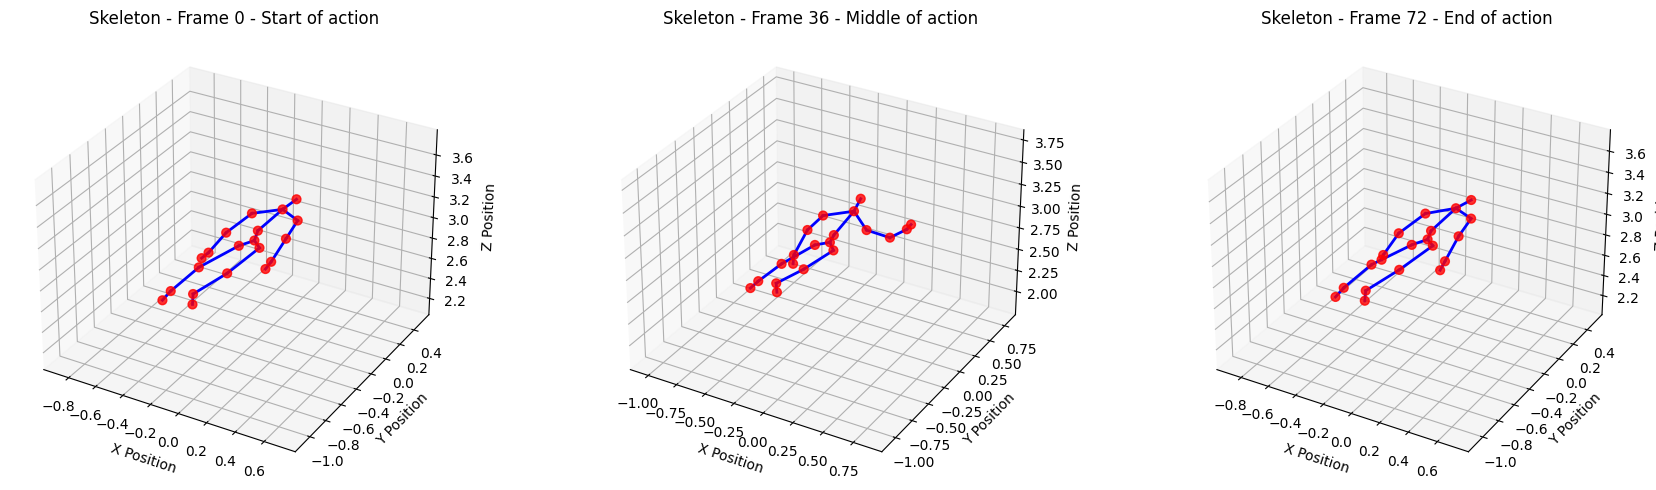


Analyzing joint trajectories...


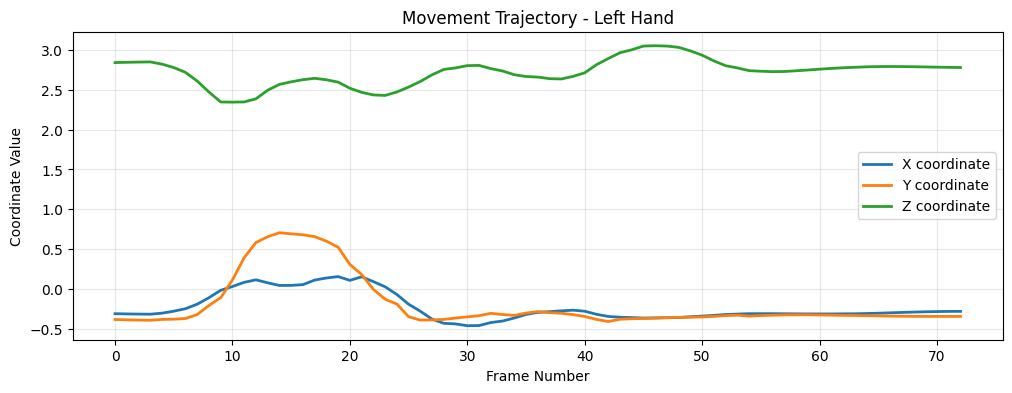

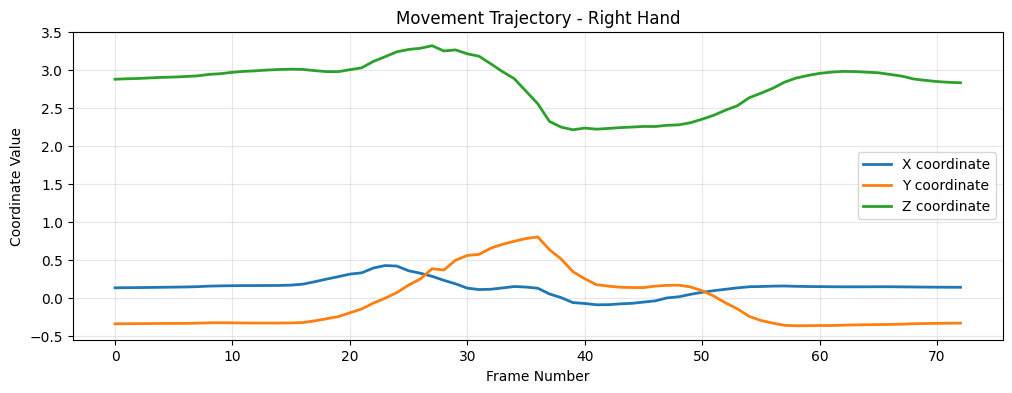

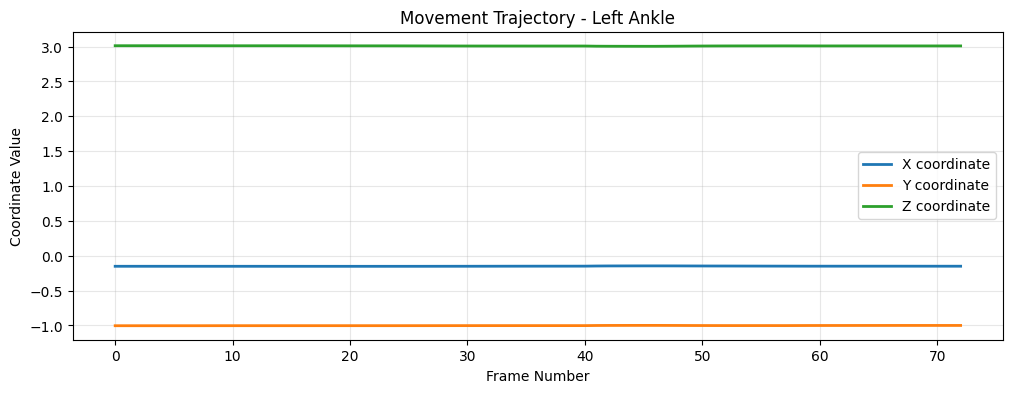

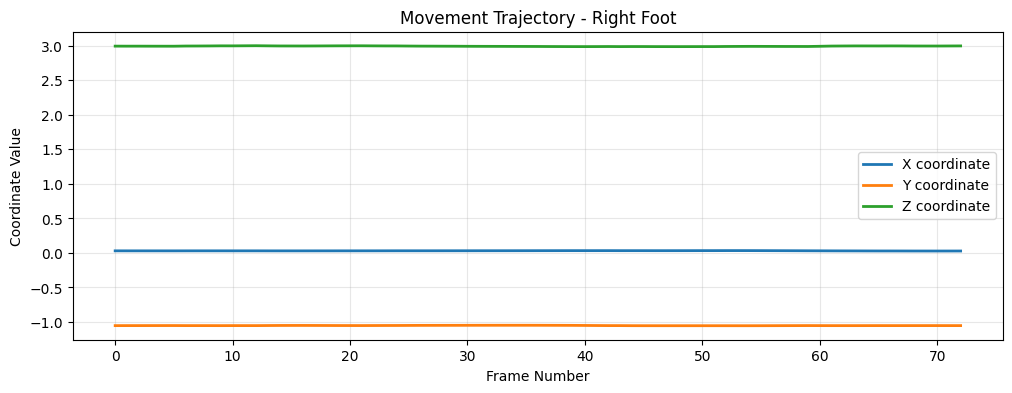


Average Movement Speed by Joint:
-----------------------------------
  head           : 0.0084 units/frame
  shoulder_center: 0.0057 units/frame
  spine          : 0.0030 units/frame
  hip_center     : 0.0046 units/frame
  left_shoulder  : 0.0092 units/frame
  left_elbow     : 0.0292 units/frame
  left_wrist     : 0.0543 units/frame
  left_hand      : 0.0632 units/frame
  right_shoulder : 0.0152 units/frame
  right_elbow    : 0.0343 units/frame
  right_wrist    : 0.0513 units/frame
  right_hand     : 0.0585 units/frame
  left_hip       : 0.0066 units/frame
  left_knee      : 0.0022 units/frame
  left_ankle     : 0.0003 units/frame
  left_foot      : 0.0005 units/frame
  right_hip      : 0.0066 units/frame
  right_knee     : 0.0028 units/frame
  right_ankle    : 0.0003 units/frame
  right_foot     : 0.0008 units/frame


In [2]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
from collections import Counter

class UTD_MHAD_Skeleton_Analyzer:
    def __init__(self, data_folder="/kaggle/input/skeleton/Skeleton"):
        self.data_folder = Path(data_folder)
        # Standard joint names for the 20-joint skeleton
        self.joint_names = [
            'head', 'shoulder_center', 'spine', 'hip_center',
            'left_shoulder', 'left_elbow', 'left_wrist', 'left_hand',
            'right_shoulder', 'right_elbow', 'right_wrist', 'right_hand',
            'left_hip', 'left_knee', 'left_ankle', 'left_foot',
            'right_hip', 'right_knee', 'right_ankle', 'right_foot'
        ]
        # Bone connections between joints
        self.bones = [
            (0, 1), (1, 2), (2, 3),  # spine chain
            (1, 4), (4, 5), (5, 6), (6, 7),  # left arm
            (1, 8), (8, 9), (9, 10), (10, 11),  # right arm
            (3, 12), (12, 13), (13, 14), (14, 15),  # left leg
            (3, 16), (16, 17), (17, 18), (18, 19)   # right leg
        ]

    def normalize_skeleton(self, skeleton_array):
        if skeleton_array.shape[1] == 3:  # Already in correct format
            return skeleton_array
        elif skeleton_array.shape[0] == 3:  # (3, num_joints, num_frames)
            return skeleton_array.transpose(1, 0, 2)
        elif skeleton_array.shape[2] == 3:  # (num_joints, num_frames, 3)
            return skeleton_array.transpose(0, 2, 1)
        else:
            raise ValueError(f"Unexpected skeleton shape: {skeleton_array.shape}")

    def load_skeleton_file(self, file_path):
        try:
            mat_data = scipy.io.loadmat(str(file_path))
            
            # Look for the skeleton data (usually 'd_skel' or similar)
            for key in mat_data:
                if not key.startswith('__') and isinstance(mat_data[key], np.ndarray) and mat_data[key].ndim == 3:
                    return self.normalize_skeleton(mat_data[key])
            
            raise ValueError(f"No 3D skeleton data found in {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    def inspect_skeleton_data(self, skeleton_data):
        num_joints, _, num_frames = skeleton_data.shape
        
        print(f"\nSkeleton Data:")
        print(f"  Shape: {skeleton_data.shape} (joints, coordinates, frames)")
        print(f"  Joints: {num_joints}, Frames: {num_frames}")
        
        # Show first frame positions for key joints
        print("\nFirst frame positions (key joints):")
        key_joints = [0, 4, 8, 12, 16]  # head, left shoulder, right shoulder, left hip, right hip
        for joint_idx in key_joints:
            if joint_idx < num_joints:
                pos = skeleton_data[joint_idx, :, 0]
                name = self.joint_names[joint_idx]
                print(f"  {name:15}: ({pos[0]:6.2f}, {pos[1]:6.2f}, {pos[2]:6.2f})")

    def plot_skeleton_3d(self, skeleton_data, frame_num=0, ax=None, title_suffix=""):
        if ax is None:
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')

        frame_data = skeleton_data[:, :, frame_num]
        x, y, z = frame_data[:, 0], frame_data[:, 1], frame_data[:, 2]

        # Plot joints as points
        ax.scatter(x, y, z, s=40, alpha=0.8, c='red')
        
        # Plot bones as lines
        for start_joint, end_joint in self.bones:
            if end_joint < len(frame_data):
                start_pos, end_pos = frame_data[start_joint], frame_data[end_joint]
                ax.plot([start_pos[0], end_pos[0]], 
                       [start_pos[1], end_pos[1]], 
                       [start_pos[2], end_pos[2]], 'b-', linewidth=2)

        ax.set_xlabel('X Position'); ax.set_ylabel('Y Position'); ax.set_zlabel('Z Position')
        
        # Use file info for title if available
        title = f'Skeleton - Frame {frame_num}'
        if title_suffix:
            title += f" - {title_suffix}"
        ax.set_title(title)
        
        # Set equal aspect ratio for proper 3D visualization
        self._set_3d_axes_equal(ax)
        return ax

    def _set_3d_axes_equal(self, ax):
        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        
        x_range = abs(x_limits[1] - x_limits[0])
        y_range = abs(y_limits[1] - y_limits[0])
        z_range = abs(z_limits[1] - z_limits[0])
        
        max_range = max(x_range, y_range, z_range)
        
        mid_x = np.mean(x_limits)
        mid_y = np.mean(y_limits)
        mid_z = np.mean(z_limits)
        
        ax.set_xlim3d([mid_x - max_range/2, mid_x + max_range/2])
        ax.set_ylim3d([mid_y - max_range/2, mid_y + max_range/2])
        ax.set_zlim3d([mid_z - max_range/2, mid_z + max_range/2])

    def plot_joint_trajectory(self, skeleton_data, joint_index, joint_name=None):
        fig, ax = plt.subplots(figsize=(12, 4))
        joint_data = skeleton_data[joint_index, :, :]
        frames = range(skeleton_data.shape[2])
        
        # Plot X, Y, Z coordinates over time
        ax.plot(frames, joint_data[0, :], label='X coordinate', linewidth=2)
        ax.plot(frames, joint_data[1, :], label='Y coordinate', linewidth=2)
        ax.plot(frames, joint_data[2, :], label='Z coordinate', linewidth=2)
        
        if joint_name is None:
            joint_name = self.joint_names[joint_index] if joint_index < len(self.joint_names) else f"Joint {joint_index}"
        
        ax.set_xlabel('Frame Number')
        ax.set_ylabel('Coordinate Value')
        ax.set_title(f'Movement Trajectory - {joint_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        return fig

    def analyze_movement_velocity(self, skeleton_data):
        velocities = []
        print("\nAverage Movement Speed by Joint:")
        print("-" * 35)
        
        for joint_idx in range(skeleton_data.shape[0]):
            # Calculate displacement between consecutive frames
            displacement = np.diff(skeleton_data[joint_idx, :, :], axis=1)
            # Compute speed as magnitude of displacement vector
            speed = np.linalg.norm(displacement, axis=0)
            avg_speed = speed.mean()
            velocities.append(avg_speed)
            
            joint_name = self.joint_names[joint_idx] if joint_idx < len(self.joint_names) else f"j{joint_idx}"
            print(f"  {joint_name:15}: {avg_speed:.4f} units/frame")
        
        return velocities

def demonstrate_skeleton_analysis(data_folder="/kaggle/input/skeleton/Skeleton"):
    analyzer = UTD_MHAD_Skeleton_Analyzer(data_folder)
    
    # Find skeleton files
    skeleton_files = list(Path(data_folder).glob("*.mat"))
    if not skeleton_files:
        print("No skeleton files found in the directory!")
        return
    
    print(f"Found {len(skeleton_files)} skeleton files")
    
    # Load and analyze the first file
    first_file = skeleton_files[0]
    print(f"\nAnalyzing: {first_file.name}")
    
    file_info = parse_filename_details(first_file)
    print(f"Action: {file_info['action_description']}")
    print(f"Subject: {file_info['subject_id']}, Trial: {file_info['trial_num']}")
    
    skeleton_data = analyzer.load_skeleton_file(first_file)
    if skeleton_data is None:
        print("Failed to load skeleton data")
        return
    
    analyzer.inspect_skeleton_data(skeleton_data)
    
    
    # Plot key frames: start, middle, end
    fig = plt.figure(figsize=(18, 5))
    total_frames = skeleton_data.shape[2]
    key_frames = [0, total_frames//2, total_frames-1]
    frame_labels = ["Start", "Middle", "End"]
    
    for i, (frame, label) in enumerate(zip(key_frames, frame_labels)):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        analyzer.plot_skeleton_3d(skeleton_data, frame, ax, f"{label} of action")
    
    plt.tight_layout()
    plt.show()
    
    print("\nAnalyzing joint trajectories...")
    key_joints = [
        (7, "Left Hand"), 
        (11, "Right Hand"), 
        (14, "Left Ankle"), 
        (19, "Right Foot")
    ]
    
    for joint_idx, joint_name in key_joints:
        if joint_idx < skeleton_data.shape[0]:
            analyzer.plot_joint_trajectory(skeleton_data, joint_idx, joint_name)
            plt.show()
    
    # Analyze movement patterns
    analyzer.analyze_movement_velocity(skeleton_data)

if __name__ == "__main__":
    demonstrate_skeleton_analysis()

In [3]:
ACTION_DESCRIPTIONS = {
    'a1': 'right arm swipe to the left',
    'a2': 'right arm swipe to the right', 
    'a3': 'right hand wave',
    'a4': 'two hand front clap',
    'a5': 'right arm throw',
    'a6': 'cross arms in the chest',
    'a7': 'basketball shoot',
    'a8': 'right hand draw x',
    'a9': 'right hand draw circle (clockwise)',
    'a10': 'right hand draw circle (counter clockwise)',
    'a11': 'draw triangle',
    'a12': 'bowling (right hand)',
    'a13': 'front boxing',
    'a14': 'baseball swing from right',
    'a15': 'tennis right hand forehand swing',
    'a16': 'arm curl (two arms)',
    'a17': 'tennis serve',
    'a18': 'two hand push',
    'a19': 'right hand knock on door',
    'a20': 'right hand catch an object',
    'a21': 'right hand pick up and throw',
    'a22': 'jogging in place',
    'a23': 'walking in place',
    'a24': 'sit to stand',
    'a25': 'stand to sit',
    'a26': 'forward lunge (left foot forward)',
    'a27': 'squat (two arms stretch out)'
}

def parse_filename_details(file_path):
    from pathlib import Path
    
    filename = Path(file_path).stem
    parts = filename.split('_')
    
    file_details = {
        'filename': filename,
        'action_id': parts[0] if len(parts) > 0 else 'unknown',
        'subject_id': parts[1] if len(parts) > 1 else 'unknown',
        'trial_num': parts[2] if len(parts) > 2 else 'unknown',
        'data_type': parts[3] if len(parts) > 3 else 'skeleton'
    }
    
    # Look up the full action description
    file_details['action_description'] = ACTION_DESCRIPTIONS.get(
        file_details['action_id'], 
        'Unknown Action'
    )
    
    return file_details

def run_dataset_analysis(data_directory="/kaggle/input/skeleton/Skeleton"):
    analyzer = UTD_MHAD_Skeleton_Analyzer(data_directory)
    data_directory = Path(data_directory)
    
    
    # Find all skeleton files
    skeleton_files = list(data_directory.glob("*.mat"))
    print(f"Found {len(skeleton_files)} skeleton files")
    
    if not skeleton_files:
        print("No skeleton files found in the specified directory!")
        return None, None, []
    
    # Initialize containers for our analysis
    file_details_list = []
    file_statistics = []
    problematic_files = []
    
    sample_size = min(50, len(skeleton_files))
    
    # Process each file and collect statistics
    for idx, file_path in enumerate(skeleton_files[:50]):        
        try:
            # Parse file information
            file_details = parse_filename_details(file_path)
            file_details_list.append(file_details)
            
            # Load and analyze the skeleton data
            skeleton_data = analyzer.load_skeleton_file(file_path)
            if skeleton_data is not None:
                joints_count, _, frames_count = skeleton_data.shape
                
                # Calculate basic statistics
                all_coordinates = skeleton_data.reshape(-1, 3)
                file_stats = {
                    'filename': file_details['filename'],
                    'action_id': file_details['action_id'],
                    'action_description': file_details['action_description'],
                    'subject_id': file_details['subject_id'],
                    'trial_num': file_details['trial_num'],
                    'joints_count': joints_count,
                    'frames_count': frames_count,
                    'x_range': (all_coordinates[:, 0].min(), all_coordinates[:, 0].max()),
                    'y_range': (all_coordinates[:, 1].min(), all_coordinates[:, 1].max()),
                    'z_range': (all_coordinates[:, 2].min(), all_coordinates[:, 2].max()),
                }
                file_statistics.append(file_stats)
            else:
                problematic_files.append(str(file_path))
                
        except Exception as error:
            problematic_files.append(f"{file_path} - {str(error)}")
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(file_statistics) if file_statistics else pd.DataFrame()
    
    print("\n. DATASET COMPOSITION")
    print("-" * 40)
    
    if file_details_list:
        subjects = [details['subject_id'] for details in file_details_list]
        actions = [details['action_id'] for details in file_details_list]
        
        print(f"Unique subjects in sample: {len(set(subjects))}")
        print(f"Unique actions in sample: {len(set(actions))}")
        
        print("\nSubject distribution:")
        subject_distribution = Counter(subjects)
        for subject, count in subject_distribution.most_common():
            print(f"  {subject}: {count} recordings")
        
        print("\nAction distribution:")
        action_distribution = Counter(actions)
        for action, count in action_distribution.most_common():
            action_desc = ACTION_DESCRIPTIONS.get(action, 'Unknown')
            print(f"  {action}: {count:2d} recordings - {action_desc}")
    
    return stats_df, file_details_list, problematic_files

df_analysis, file_info, bad_files = run_dataset_analysis()

if df_analysis is not None and not df_analysis.empty:
    print("\nSample of analyzed files:")
    print(df_analysis[['filename', 'action_id', 'action_description', 'subject_id', 'frames_count']].head())

Found 861 skeleton files

. DATASET COMPOSITION
----------------------------------------
Unique subjects in sample: 8
Unique actions in sample: 23

Subject distribution:
  s3: 9 recordings
  s6: 8 recordings
  s4: 8 recordings
  s2: 6 recordings
  s7: 6 recordings
  s8: 5 recordings
  s1: 4 recordings
  s5: 4 recordings

Action distribution:
  a17:  6 recordings - tennis serve
  a3:  5 recordings - right hand wave
  a27:  4 recordings - squat (two arms stretch out)
  a11:  3 recordings - draw triangle
  a4:  3 recordings - two hand front clap
  a19:  3 recordings - right hand knock on door
  a13:  2 recordings - front boxing
  a25:  2 recordings - stand to sit
  a12:  2 recordings - bowling (right hand)
  a16:  2 recordings - arm curl (two arms)
  a20:  2 recordings - right hand catch an object
  a8:  2 recordings - right hand draw x
  a23:  2 recordings - walking in place
  a22:  2 recordings - jogging in place
  a9:  2 recordings - right hand draw circle (clockwise)
  a1:  1 recordin


📁 FILE NAMING PATTERN: action_subject_trial_skeleton.mat
   ├── action = Action ID (a1 through a27)
   ├── subject = Person performing (s1 through s8)
   ├── trial = Repetition number (t1 through t4)
   └── skeleton = Type of data (always 'skeleton' for our files)

REPRESENTATIVE ACTIONS:

a17 - tennis serve:
   Total recordings: 6
   Performed by subjects: ['s1', 's3', 's5', 's6', 's7']
   Trial numbers: ['t1', 't2', 't4']
   Duration range: 56-75 frames
      Example: a17_s1_t2_skeleton (73 frames)
      Example: a17_s6_t1_skeleton (74 frames)

a3 - right hand wave:
   Total recordings: 5
   Performed by subjects: ['s3', 's4', 's6', 's7', 's8']
   Trial numbers: ['t1', 't2', 't3', 't4']
   Duration range: 49-70 frames
      Example: a3_s8_t2_skeleton (58 frames)
      Example: a3_s7_t3_skeleton (49 frames)

a27 - squat (two arms stretch out):
   Total recordings: 4
   Performed by subjects: ['s1', 's2', 's4', 's7']
   Trial numbers: ['t1', 't2', 't4']
   Duration range: 53-100 frame

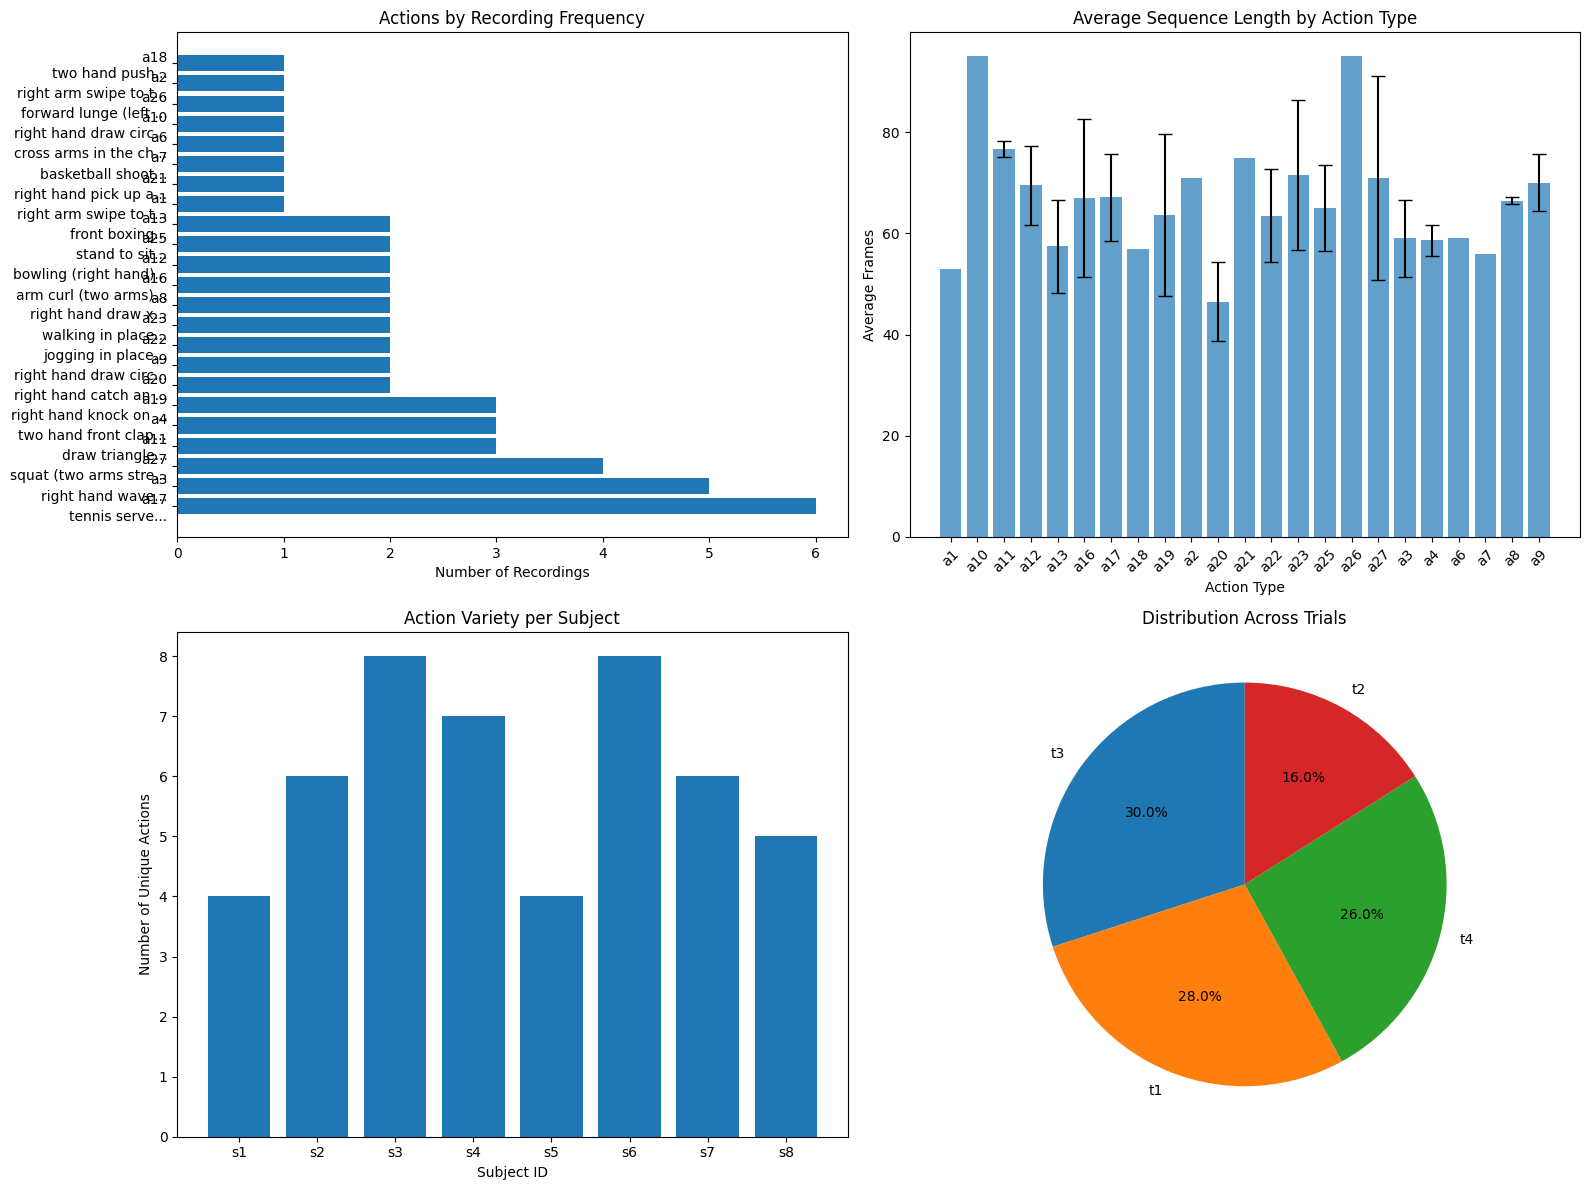

EXAMPLES

 TENNIS SERVE (a17) - 6 files means:
   6 separate performances of tennis serve by different people:
   - Subject s1, Trial t2: 73 frames
   - Subject s6, Trial t1: 74 frames
   - Subject s7, Trial t1: 75 frames
   - Subject s5, Trial t1: 68 frames
   - Subject s3, Trial t4: 56 frames
   - Subject s3, Trial t1: 57 frames

 DATA STRUCTURE:
   File: a17_s1_t2_skeleton
   73 frames = 73 consecutive time points
   Each frame contains 20 joints × 3 coordinates (x,y,z)
   Total values: 73 × 20 × 3 = 4380 data points

 UNDERSTANDING TRIALS:
   t1, t2, t3, t4 = Different repetitions of the same action
   Same person performing the same action multiple times
   Captures natural variation in how people perform movements


In [4]:
import matplotlib.pyplot as plt

def describe_dataset_organization(stats_df):
    
    print("\n📁 FILE NAMING PATTERN: action_subject_trial_skeleton.mat")
    print("   ├── action = Action ID (a1 through a27)")
    print("   ├── subject = Person performing (s1 through s8)") 
    print("   ├── trial = Repetition number (t1 through t4)")
    print("   └── skeleton = Type of data (always 'skeleton' for our files)\n")
    
    print("REPRESENTATIVE ACTIONS:")
    action_frequencies = stats_df['action_id'].value_counts()
    
    # Look at the most common actions
    for action_id, frequency in action_frequencies.head(5).items():
        action_desc = ACTION_DESCRIPTIONS[action_id]
        action_samples = stats_df[stats_df['action_id'] == action_id]
        subjects_in_action = action_samples['subject_id'].unique()
        trials_in_action = action_samples['trial_num'].unique()
        
        print(f"\n{action_id} - {action_desc}:")
        print(f"   Total recordings: {frequency}")
        print(f"   Performed by subjects: {sorted(subjects_in_action)}")
        print(f"   Trial numbers: {sorted(trials_in_action)}")
        print(f"   Duration range: {action_samples['frames_count'].min()}-{action_samples['frames_count'].max()} frames")
        
        # Show a couple of specific files
        sample_files = action_samples.head(2)
        for _, file_row in sample_files.iterrows():
            print(f"      Example: {file_row['filename']} ({file_row['frames_count']} frames)")
    
    print("\n SUBJECT SUMMARY:")
    subject_summary = stats_df['subject_id'].value_counts()
    for subject, count in subject_summary.items():
        unique_actions = stats_df[stats_df['subject_id'] == subject]['action_id'].nunique()
        print(f"   {subject}: {count} recordings, {unique_actions} different actions")
    
    print("\n TRIAL DISTRIBUTION:")
    trial_counts = stats_df['trial_num'].value_counts()
    for trial, count in trial_counts.items():
        print(f"   {trial}: {count} recordings")

def create_analysis_plots(stats_df):
    
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Most common actions
    action_counts = stats_df['action_id'].value_counts()
    action_labels = [f"{action_id}\n{ACTION_DESCRIPTIONS[action_id][:20]}..." 
                    for action_id in action_counts.index]
    
    axes[0,0].barh(action_labels, action_counts.values)
    axes[0,0].set_xlabel('Number of Recordings')
    axes[0,0].set_title('Actions by Recording Frequency')
    
    # Plot 2: Frame length variation by action
    action_groups = stats_df.groupby('action_id')['frames_count']
    avg_frames = action_groups.mean()
    frame_std = action_groups.std()
    
    axes[0,1].bar(range(len(avg_frames)), avg_frames.values, 
                  yerr=frame_std.values, alpha=0.7, capsize=5)
    axes[0,1].set_xlabel('Action Type')
    axes[0,1].set_ylabel('Average Frames')
    axes[0,1].set_title('Average Sequence Length by Action Type')
    axes[0,1].set_xticks(range(len(avg_frames)))
    axes[0,1].set_xticklabels(avg_frames.index, rotation=45)
    
    # Plot 3: Subject participation
    subjects_unique_actions = stats_df.groupby('subject_id')['action_id'].nunique()
    axes[1,0].bar(subjects_unique_actions.index, subjects_unique_actions.values)
    axes[1,0].set_xlabel('Subject ID')
    axes[1,0].set_ylabel('Number of Unique Actions')
    axes[1,0].set_title('Action Variety per Subject')
    
    # Plot 4: Trial distribution
    trial_distribution = stats_df['trial_num'].value_counts()
    axes[1,1].pie(trial_distribution.values, labels=trial_distribution.index, 
                  autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Distribution Across Trials')
    
    plt.tight_layout()
    plt.show()

describe_dataset_organization(df_analysis)
create_analysis_plots(df_analysis)

# some examples
print("EXAMPLES")

# Example: Tennis Serve analysis
print("\n TENNIS SERVE (a17) - 6 files means:")
a17_recordings = df_analysis[df_analysis['action_id'] == 'a17']
print("   6 separate performances of tennis serve by different people:")
for _, recording_info in a17_recordings.iterrows():
    print(f"   - Subject {recording_info['subject_id']}, Trial {recording_info['trial_num']}: {recording_info['frames_count']} frames")

# Example: Understanding the data structure
print(f"\n DATA STRUCTURE:")
sample_recording = df_analysis.iloc[0]
print(f"   File: {sample_recording['filename']}")
print(f"   {sample_recording['frames_count']} frames = {sample_recording['frames_count']} consecutive time points")
print(f"   Each frame contains 20 joints × 3 coordinates (x,y,z)")
print(f"   Total values: {sample_recording['frames_count']} × 20 × 3 = {sample_recording['frames_count'] * 20 * 3} data points")

# Example: What trials represent
print(f"\n UNDERSTANDING TRIALS:")
print("   t1, t2, t3, t4 = Different repetitions of the same action")
print("   Same person performing the same action multiple times")
print("   Captures natural variation in how people perform movements")

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from pathlib import Path
from IPython.display import HTML, display

def create_skeleton_animation(analyzer, file_path, fps=10, output_path="skeleton_animation.mp4"):
    skeleton_data = analyzer.load_skeleton_file(file_path)
    
    if skeleton_data is None:
        return None
    
    num_frames = skeleton_data.shape[2]
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set up the initial plot
    frame_data = skeleton_data[:, :, 0]
    x, y, z = frame_data[:, 0], frame_data[:, 1], frame_data[:, 2]
    
    # Plot joints
    scatter = ax.scatter(x, y, z, s=50, c='red', alpha=0.8)
    
    # Plot bones
    lines = []
    for bone in analyzer.bones:
        if bone[1] < len(frame_data):
            a, b = frame_data[bone[0]], frame_data[bone[1]]
            line, = ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], 'b-', linewidth=2)
            lines.append(line)
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y') 
    ax.set_zlabel('Z')
    title = ax.set_title(f'Frame: 0/{num_frames-1}')
    
    # Set equal aspect ratio
    def set_axes_equal(ax):
        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        
        x_range = abs(x_limits[1] - x_limits[0])
        y_range = abs(y_limits[1] - y_limits[0])
        z_range = abs(z_limits[1] - z_limits[0])
        
        max_range = max(x_range, y_range, z_range)
        
        mid_x = np.mean(x_limits)
        mid_y = np.mean(y_limits)
        mid_z = np.mean(z_limits)
        
        ax.set_xlim3d([mid_x - max_range/2, mid_x + max_range/2])
        ax.set_ylim3d([mid_y - max_range/2, mid_y + max_range/2])
        ax.set_zlim3d([mid_z - max_range/2, mid_z + max_range/2])
    
    set_axes_equal(ax)
    
    # Animation update function
    def update(frame):
        frame_data = skeleton_data[:, :, frame]
        x, y, z = frame_data[:, 0], frame_data[:, 1], frame_data[:, 2]
        
        # Update scatter plot
        scatter._offsets3d = (x, y, z)
        
        # Update bones
        for i, bone in enumerate(analyzer.bones):
            if bone[1] < len(frame_data) and i < len(lines):
                a, b = frame_data[bone[0]], frame_data[bone[1]]
                lines[i].set_data_3d([a[0], b[0]], [a[1], b[1]], [a[2], b[2]])
        
        # Update title
        title.set_text(f'Frame: {frame}/{num_frames-1}')
        
        return [scatter] + lines + [title]
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, update, frames=num_frames, 
        interval=1000/fps, blit=True, repeat=True
    )
    
    # Save as video file
    anim.save(output_path, writer='ffmpeg', fps=fps, dpi=100)
    
    return anim, fig

# Usage example:
if __name__ == "__main__":
    # Initialize your analyzer
    analyzer = UTD_MHAD_Skeleton_Analyzer()  # Make sure this class is defined
    
    # skeleton file
    mat_files = list(Path("/kaggle/input/skeletons/Skeleton").glob("*.mat"))
    if mat_files:
        example_file = mat_files[0]
        
        # Create and display the animation
        anim, fig = create_skeleton_animation(analyzer, example_file, fps=15, output_path="skeleton_animation.mp4")
        
        # Display the animation inline
        plt.close(fig)  # Close the figure to avoid double display
        display(HTML(anim.to_html5_video()))

# Model Training

In [15]:
# Load and preprocess all skeleton data
def prepare_training_data(analyzer, file_details_list, data_directory="/kaggle/input/skeleton/Skeleton"):
    """Prepare X features and y labels for training"""
    X = []  # Features
    y = []  # Labels (action_ids)
    
    for file_info in file_details_list:
        # Reconstruct the full file path
        filename = file_info['filename'] + '.mat'
        file_path = Path(data_directory) / filename
        
        skeleton_data = analyzer.load_skeleton_file(file_path)
        
        if skeleton_data is not None:
            features = extract_features(skeleton_data)
            X.extend(features)
            y.extend([file_info['action_id']] * len(features))
    return X, y

In [16]:
def extract_features(skeleton_data):
    datas = []
    frame_size = len(skeleton_data[0][0])-1
    for each in range(0, frame_size):
        data_flatten = skeleton_data[:,:,each].flatten()
        datas.append(data_flatten)
    return datas

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X, y = prepare_training_data(analyzer, file_info)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,
    random_state=42
)

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Show performance per action
print(classification_report(y_test, y_pred))

Accuracy: 0.998767
              precision    recall  f1-score   support

          a1       1.00      1.00      1.00        10
         a10       1.00      1.00      1.00        30
         a11       1.00      1.00      1.00        65
         a12       1.00      0.97      0.98        29
         a13       1.00      1.00      1.00        30
         a16       1.00      1.00      1.00        33
         a17       0.99      1.00      1.00       112
         a18       1.00      1.00      1.00        15
         a19       1.00      1.00      1.00        49
          a2       1.00      1.00      1.00        11
         a20       1.00      1.00      1.00        27
         a21       1.00      1.00      1.00        23
         a22       1.00      1.00      1.00        26
         a23       1.00      1.00      1.00        33
         a25       1.00      1.00      1.00        23
         a26       1.00      1.00      1.00        17
         a27       1.00      1.00      1.00        62
        

In [20]:
def predict_gesture(analyzer, new_skeleton_file):
    # Load and preprocess new data
    skeleton_data = analyzer.load_skeleton_file(new_skeleton_file)
    features = extract_features(skeleton_data)
    
    # Predict
    prediction = model.predict(features.reshape(1, -1))
    action_id = label_encoder.inverse_transform(prediction)[0]
    
    return ACTION_DESCRIPTIONS[action_id]